### Implementing Long Short-Term Memory to detect and classify Parkinsons' Freezing of Gait types in time series data

In [116]:
using Pkg

# Pkg.add("CSV")
# Pkg.add("NNlib")
# Pkg.add("DataFrames")
# Pkg.add("Distributions")
# Pkg.add("ResumableFunctions")
# Pkg.add("Flux")
# Pkg.add("BSON")
# Pkg.add("MLDataUtils")
# Pkg.add("Plots")

In [117]:
using Flux
using Flux: @epochs, batch, throttle

using CSV
using BSON: @save, @load
using Plots
using NNlib
using Random
using DataFrames
using Distributions
using ResumableFunctions
using MLDataUtils

In [118]:
parkinson_train = CSV.read("./train_data.csv", DataFrame)
parkinson_validation = CSV.read("./validation_data.csv", DataFrame)
parkinson_test = CSV.read("./test_data.csv", DataFrame)


Row,Id,Subject,Visit,Test,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,event
,String15,String7,Int64,Int64,String3,Int64,Float64,Float64,Float64,Int64,Int64,Int64,String15
1,7468af035f,48fd62,2,1,on,9794,-9.85425,0.0322571,0.875734,0,1,0,Turn
2,7263d0d3f4,312788,20,2,on,1078,-8.28304,-0.173895,2.51757,0,0,0,Normal
3,2a082fe090,516a67,2,1,off,5654,-9.26268,-1.06818,1.12145,0,0,0,Normal
4,98c313f19c,fa8764,19,1,on,3049,-19.7102,-0.122622,0.403162,0,0,0,Normal
5,16464efd8d,4b39ac,13,3,off,8502,-11.5049,-2.36527,1.16983,0,0,0,Normal
6,7d7c4e6da1,bc3908,3,1,on,1754,-9.42164,-0.403836,4.60564,0,0,0,Normal
7,d8ee255fab,3b2b7a,2,2,off,2311,-7.14169,0.909601,4.68574,0,1,0,Turn
8,8fc05fabee,7eb666,2,3,off,10421,-9.32675,-0.578011,3.55733,0,0,0,Normal
9,6e05dd955f,93f49f,13,2,on,6767,-10.3758,-0.63742,-0.26567,0,0,0,Normal


In [119]:
@resumable function data_loader(dataframe, num_sequences, num_selected_sequences, batch_size; labels=["StartHesitation", "Turn", "Walking", "Normal"])
    @assert num_selected_sequences <= num_sequences
    
    df = deepcopy(dataframe)
    
    sequences = collect(1:num_sequences)
    shuffle!(sequences)

    # Sending to the model
    for i in 1:num_selected_sequences
        # if benne van a random generalt elemek tombunkben
        x = hcat(
            df[!, "AccV"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size],
            df[!, "AccML"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size],
            df[!, "AccAP"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size]
        )
    
        y = Flux.onehotbatch(df[!, "event"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size], labels)
        
        @yield x, y
    end
end

data_loader (generic function with 1 method)

In [ ]:
function accuracy(model, x_test, y_test)
    correct = 0
    return(correct / length(y_test))
end

In [120]:
function init_params(in::Integer, out::Integer; mean=0.0, std=1.0)
    [
        in, out,
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wf
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wi
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wc
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bf
        rand(Truncated(Normal(mean, std), -1, 1), out), # bi
        rand(Truncated(Normal(mean, std), -1, 1), out), # bc
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo

        # both the Long-Term and Short-Term memories are initialized with 0 values
        zeros(out),  # c
        zeros(out),  # h
        true # update_memory
    ]
end


init_params (generic function with 1 method)

In [121]:
# implementing the forwarding method which is used in the Chaining process
function forward(x, lstm)

    for i in 1:size(x, 1)
        long_remember_percent = NNlib.sigmoid_fast((lstm.c .* lstm.wlr1) + (x[i, :] .* lstm.wlr2) + lstm.blr1)
        potential_remember_percent = NNlib.sigmoid_fast((lstm.h .* lstm.wpr1) + (x[i, :] .* lstm.wpr2) + lstm.bpr1)
        potential_memory = NNlib.tanh_fast((lstm.c .* lstm.wp1) + (x[i, :] .* lstm.wp2) + lstm.bp1)
        updated_long_memory = (lstm.c .* long_remember_percent) + (potential_memory .* potential_remember_percent)
        output_percent = NNlib.sigmoid_fast((lstm.h .* lstm.wo1) + (x[i, :] .* lstm.wo2) + lstm.bo1)
        updated_short_memory = NNlib.tanh_fast(updated_long_memory) .* output_percent

        # updating the memory
        if lstm.update_memory
            lstm.c, lstm.h = updated_long_memory, updated_short_memory
        end
    end

    lstm.c
end

forward (generic function with 1 method)

In [122]:
# custom Long Short-Term Memory layer
mutable struct LSTM
    # input and output size of the layer
    in::Integer
    out::Integer

    wlr1::Vector{Float32}
    wlr2::Vector{Float32}
    blr1::Vector{Float32}

    wpr1::Vector{Float32}
    wpr2::Vector{Float32}
    bpr1::Vector{Float32}

    wp1::Vector{Float32}
    wp2::Vector{Float32}
    bp1::Vector{Float32}

    wo1::Vector{Float32}
    wo2::Vector{Float32}
    bo1::Vector{Float32}


    # cell state (aka. long-term memory) and hidden state (aka. short-term memory)
    c::Vector{Float32}
    h::Vector{Float32}

    # prevents the model from modifying the memory state in case of testing and loss calculation
    # it needs to be set explicitely before and after calling the model(x) funtion
    update_memory::Bool
end

In [123]:
# defining the constructor
LSTM(in::Integer, out::Integer) = LSTM(init_params(in, out)...)

LSTM

In [124]:
# Overload call, so the object can be used as a function
(lstm::LSTM)(x) = forward(x, lstm)

In [125]:
# creating a functor from the struct, so that the training can optimize its parameters
Flux.@functor LSTM

In [126]:
# creating the Long Short-Term Memory layer
function LSTM((in, out)::Pair)
    LSTM(in, out) # constructor
end

LSTM

In [127]:
# explicitely defining the trainable parameters of the layer
# all the Wrights and Biases are trainable
# exceptions >> Cell State and Hidden State
# Flux.trainable(lstm::LSTM) = (lstm.Wf, lstm.Wi, lstm.Wc, lstm.Wo, lstm.bf, lstm.bi, lstm.bc, lstm.bo,)
Flux.trainable(lstm::LSTM) = (lstm.wlr1, lstm.wlr2, lstm.blr1, lstm.wpr1, lstm.wpr2, lstm.bpr1, lstm.wp1, lstm.wp2, lstm.bp1, lstm.wo1, lstm.wo2, lstm.bo1)

In [128]:
# Random generating sequences
num_sequences = 10_000
num_selected_sequences = 1_000
batch_size_train = div(size(parkinson_train, 1), num_sequences)
batch_size_validation = div(size(parkinson_validation, 1), num_sequences)

141

In [129]:
epochs = 20

input_size = batch_size_train
hidden_size = 3
num_classes = 4 

model = Chain(
    LSTM(input_size => hidden_size),
    Dense(hidden_size => 300),
    Dense(300 => num_classes),
    softmax
)

;

In [130]:
function loss(model, x, y)
    model[1].update_memory = false
    l = Flux.crossentropy.(eachrow(model(x)'), eachrow(y'))
    model[1].update_memory = true

    mean(l)
end

optimizer = ADAM(0.001)

;

In [131]:
train_losses = []
validation_losses = []

for epoch in 1:epochs

  epoch_loss = 0f0

  for (x, y) in data_loader(parkinson_train, num_sequences, num_selected_sequences, batch_size_train)
    grads = Flux.gradient(Flux.params(model)) do
      l = loss(model, x, y) 
      epoch_loss += l

      l
    end
    Flux.update!(optimizer, Flux.params(model), grads)
  end

  train_loss = epoch_loss / num_selected_sequences 
  @info "Epoch: $epoch >> Loss: $train_loss"
  append!(train_losses, train_loss)

  
  #Validation for epoch
  epoch_loss = 0f0

  for (x, y) in data_loader(parkinson_validation, num_sequences, num_selected_sequences, batch_size_validation)
      l = loss(model, x, y) 
      epoch_loss += l

      l
  end

  validation_loss = epoch_loss / num_selected_sequences 
  @info "Validation >> Loss: $validation_loss"
  append!(validation_losses, train_loss)

end

[ Info: Epoch: 1 >> Loss: 0.85286283
[ Info: Validation >> Loss: 0.8396237
[ Info: Epoch: 2 >> Loss: 0.8338522
[ Info: Validation >> Loss: 0.8385596
[ Info: Epoch: 3 >> Loss: 0.83564955
[ Info: Validation >> Loss: 0.8416065
[ Info: Epoch: 4 >> Loss: 0.83641297
[ Info: Validation >> Loss: 0.8401643
[ Info: Epoch: 5 >> Loss: 0.84133923
[ Info: Validation >> Loss: 0.83766985
[ Info: Epoch: 6 >> Loss: 0.84077007
[ Info: Validation >> Loss: 0.83950824
[ Info: Epoch: 7 >> Loss: 0.8297714
[ Info: Validation >> Loss: 0.8370264
[ Info: Epoch: 8 >> Loss: 0.83196986
[ Info: Validation >> Loss: 0.8373936
[ Info: Epoch: 9 >> Loss: 0.8336714
[ Info: Validation >> Loss: 0.8378171
[ Info: Epoch: 10 >> Loss: 0.840855
[ Info: Validation >> Loss: 0.84370816
[ Info: Epoch: 11 >> Loss: 0.8343823
[ Info: Validation >> Loss: 0.8395514
[ Info: Epoch: 12 >> Loss: 0.8312603
[ Info: Validation >> Loss: 0.83965766
[ Info: Epoch: 13 >> Loss: 0.8389892
[ Info: Validation >> Loss: 0.8353806
[ Info: Epoch: 14 >> Loss

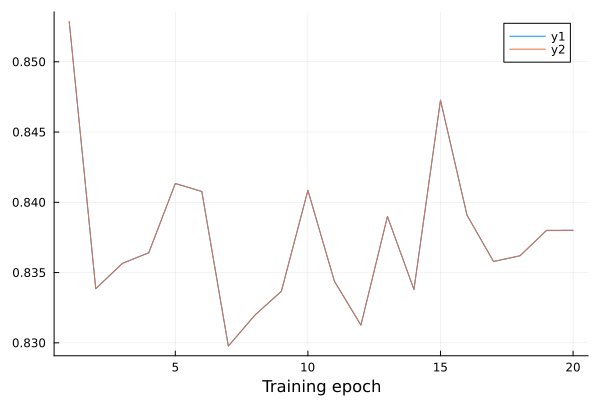

In [132]:
p = plot()
Plots.plot!(collect(1:epochs), train_losses)
Plots.plot!(collect(1:epochs), validation_losses)
xaxis!("Training epoch")

In [133]:
@save "LSTM.bson" model

In [134]:
@load "LSTM.bson" model

In [135]:
model[1].update_memory = false
model([1])

4-element Vector{Float32}:
 0.0534637
 0.24224941
 0.0349021
 0.66938484